In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import glob
import json
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import lines
from astropy.io import fits
from astropy import stats
from astropy.table import Table

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils

from myutils import *

In [2]:
dfDB_12640 = getDBinfoBOT(run='12640')
print(dfDB_12640.columns)

Index(['MAX_OBSERVED_SIGNAL', 'MAX_FRAC_DEV', 'LINEARITY_TURNOFF',
       'ROW_MEAN_VAR_SLOPE', 'PSF_SIGMA', 'GAIN_ERROR', 'GAIN',
       'CTI_LOW_PARALLEL', 'CTI_LOW_SERIAL_ERROR', 'CTI_LOW_SERIAL',
       'CTI_HIGH_SERIAL_ERROR', 'CTI_HIGH_PARALLEL', 'CTI_HIGH_SERIAL',
       'CTI_LOW_PARALLEL_ERROR', 'CTI_HIGH_PARALLEL_ERROR', 'PTC_A00',
       'PTC_NOISE', 'PTC_GAIN', 'PTC_A00_ERROR', 'PTC_TURNOFF',
       'PTC_NOISE_ERROR', 'PTC_GAIN_ERROR', 'DARK_CURRENT_MEDIAN',
       'DARK_CURRENT_95CL', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'TEARING_DETECTIONS', 'DIVISADERO_MAX_DEV',
       'BF_SLOPEY_ERR', 'BF_YCORR_ERR', 'BF_SLOPEX_ERR', 'BF_MEAN',
       'BF_SLOPEX', 'BF_SLOPEY', 'BF_XCORR_ERR', 'BF_XCORR', 'BF_YCORR',
       'TOTAL_NOISE', 'SYSTEM_NOISE', 'READ_NOISE', 'BAY', 'SLOT', 'AMP',
       'BAYTYPE'],
      dtype='object')


In [14]:
# add BAY_SLOT
dfDB_12640['BAY_SLOT'] = dfDB_12640.BAY + "_" + dfDB_12640.SLOT

Text(0.5, 1.0, 'Run 12640')

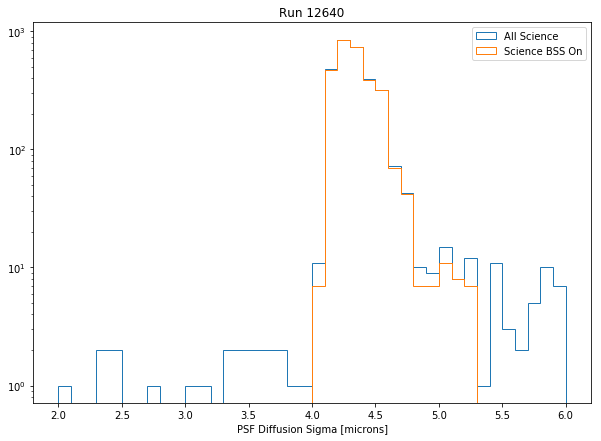

In [24]:
# plot PSF_SIGMA for all Science Rafts, removing BAY_SLOTs with BSS Off
dfScience = dfDB_12640[(dfDB_12640.BAYTYPE=='S')]
bssoff = ['R10_S00','R10_S01','R10_S02','R33_S20','R33_S21','R33_S22']
dfScienceOn = dfScience[(~dfScience['BAY_SLOT'].isin(bssoff))]

f,ax = plt.subplots(figsize=(10,7))
h = ax.hist(dfScience.PSF_SIGMA,bins=40,range=(2.0,6.0),histtype='step',label='All Science')
h = ax.hist(dfScienceOn.PSF_SIGMA,bins=40,range=(2.0,6.0),histtype='step',label='Science BSS On')

ax.set_yscale('log')
ax.set_xlabel('PSF Diffusion Sigma [microns]')
ax.legend()
ax.set_title('Run 12640')

In [26]:
# Print channels, values with Sigma>5
dfScienceOn_above = dfScienceOn[(dfScienceOn.PSF_SIGMA>5.0)]
print(dfScienceOn_above[['BAY','SLOT','AMP','PSF_SIGMA','GAIN','PTC_GAIN']])

    BAY SLOT  AMP  PSF_SIGMA      GAIN  PTC_GAIN
0   R01  S00    1       5.08  1.455618  1.458905
2   R01  S00    3       5.08  1.481395  1.486067
7   R01  S00    8       5.08  1.443349  1.452407
16  R01  S01    1       5.24  1.403146  1.388165
17  R01  S01    2       5.24  1.406203  1.396024
18  R01  S01    3       5.24  1.403463  1.395721
19  R01  S01    4       5.16  1.399784  1.390233
20  R01  S01    5       5.16  1.393763  1.385897
21  R01  S01    6       5.16  1.398029  1.388974
22  R01  S01    7       5.16  1.393683  1.381832
23  R01  S01    8       5.08  1.388311  1.379951
24  R01  S01    9       5.16  1.370627  1.370275
25  R01  S01   10       5.24  1.403827  1.394785
26  R01  S01   11       5.16  1.396447  1.387591
27  R01  S01   12       5.24  1.395782  1.385231
28  R01  S01   13       5.16  1.404313  1.402386
29  R01  S01   14       5.24  1.407497  1.409824
30  R01  S01   15       5.16  1.409303  1.413734
31  R01  S01   16       5.24  1.406773  1.410040


In [18]:
# Get BSS value for R01_S01

# get Fe55 image file
acqlinks = getBOTacqlinks(run='12636')
imgfiles = getBOTimgfiles(acqlinks['fe55_flat'],'R01','S01')

# get header info
hdu = fits.open(imgfiles[0])
#print(hdu.info())
print("BSS = ",hdu[17].header['BSSVBS'])

BSS =  30.15
